##Spark Installation

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"


In [ ]:
!pip install -q findspark
import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession
 .builder
 .appName("<app_name>")
 .getOrCreate())

In [ ]:
venue = spark.read.csv('ipl_venue.csv',inferSchema=True, header=True)
matches = spark.read.csv('ipl_matches.csv',inferSchema=True, header=True)
ipl = spark.read.csv('ipl_ball_by_ball.csv',inferSchema=True, header=True)


In [ ]:
venue.createOrReplaceTempView("venue")
matches.createOrReplaceTempView("matches")
ipl.createOrReplaceTempView("ipl")

In [ ]:
matches.show()

+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|match_id|      date|player_of_match|venue_id|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|eliminator|method|    umpire1|       umpire2|
+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|  335982|2008-04-18|    BB McCullum|      35|            0|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|   runs|          140|         N|    NA|  Asad Rauf|   RE Koertzen|
|  335983|2008-04-19|     MEK Hussey|      31|            0|     Kings XI Punjab| Chennai Super 

#Section 2

In [ ]:
#top 3 venues which hosted the eliminator matches
spark.sql("SELECT venue, COUNT(*) AS matches FROM venue INNER JOIN matches ON venue.venue_id = matches.venue_id WHERE eliminator like 'Y' GROUP BY venue ORDER BY COUNT(*) DESC LIMIT 3").show()

+--------------------+-------+
|               venue|matches|
+--------------------+-------+
|Dubai Internation...|      3|
|Sheikh Zayed Stadium|      2|
|Sardar Patel Stad...|      1|
+--------------------+-------+



In [ ]:
#Player with most number of catches in IPL history
spark.sql("SELECT fielder, COUNT(*) FROM ipl WHERE dismissal_kind like 'caught' GROUP BY fielder ORDER BY COUNT(*) DESC LIMIT 1 ").show()

+----------+--------+
|   fielder|count(1)|
+----------+--------+
|KD Karthik|      73|
+----------+--------+



In [ ]:
#Highest wicket taker in matches which were affected by Duckworth-Lewis’s method (D/L method)
spark.sql("SELECT bowler, sum(is_wicket) AS wickets FROM ipl INNER JOIN matches ON ipl.match_id = matches.match_id WHERE dismissal_kind NOT LIKE 'run out' OR dismissal_kind NOT LIKE 'retired hurt' OR dismissal_kind NOT LIKE 'NA' GROUP BY bowler ORDER BY wickets DESC LIMIT 1").show()

+--------+-------+
|  bowler|wickets|
+--------+-------+
|DJ Bravo|    130|
+--------+-------+



In [ ]:
#highest strike rate by a batsman in non powerplay overs(7-20 overs)
spark.sql("SELECT batsman, (SUM(batsman_runs)* 100)/ COUNT(ball) AS strike_rate FROM ipl WHERE extras_type like 'NA' GROUP BY batsman ORDER BY strike_rate DESC LIMIT 1").show()

+----------+-----------+
|   batsman|strike_rate|
+----------+-----------+
|B Stanlake|      250.0|
+----------+-----------+



In [ ]:
#highest extra runs in a venue (stadium, city)
spark.sql("SELECT venue,city FROM venue where venue_id = (SELECT venue_id FROM matches INNER JOIN ipl ON matches.match_id = ipl.match_id GROUP BY venue_id ORDER BY SUM(extras_type) LIMIT 1)").show()

+--------------------+----------+
|               venue|      city|
+--------------------+----------+
|Punjab Cricket As...|Chandigarh|
+--------------------+----------+



In [ ]:
#cricketers with the most number of players of the match award in neutral venues
spark.sql("SELECT player_of_match, COUNT(*) FROM matches WHERE neutral_venue = 1 GROUP BY player_of_match ORDER BY COUNT(*) DESC LIMIT 1").show()

+---------------+--------+
|player_of_match|count(1)|
+---------------+--------+
|      YK Pathan|       3|
+---------------+--------+



In [ ]:
#a list of top 10 players with the highest batting average
spark.sql("SELECT batsman, SUM(batsman_runs)/SUM(is_wicket) AS avg FROM ipl GROUP BY batsman ORDER BY avg DESC LIMIT 10").show()

+--------------+------------------+
|       batsman|               avg|
+--------------+------------------+
|       TM Head|             120.0|
|    RD Gaikwad|              92.0|
|    MN van Wyk|55.666666666666664|
|     V Shankar|            52.875|
|  Kamran Akmal|              50.5|
|     ML Hayden|              48.0|
|       HM Amla|              48.0|
|      CH Gayle| 46.39655172413793|
|AB de Villiers| 46.22950819672131|
|    UT Khawaja|              46.0|
+--------------+------------------+



In [ ]:
# find out who has officiated (as an umpire) the most number of matches in IPL
spark.sql("SELECT umpire2, COUNT(match_id) FROM matches GROUP BY umpire2 ORDER BY COUNT(match_id) DESC limit 1").show()

+-------+---------------+
|umpire2|count(match_id)|
+-------+---------------+
| S Ravi|             84|
+-------+---------------+



In [ ]:
#venue details of the match where V Kohli scored his highest individual runs in IPL.
spark.sql("SELECT * FROM matches WHERE match_id IN (SELECT match_id FROM ipl WHERE batsman like 'Virat Kohli' GROUP BY match_id ORDER BY SUM(batsman_runs) DESC LIMIT 1)").show()

+--------+----+---------------+--------+-------------+-----+-----+-----------+-------------+------+------+-------------+----------+------+-------+-------+
|match_id|date|player_of_match|venue_id|neutral_venue|team1|team2|toss_winner|toss_decision|winner|result|result_margin|eliminator|method|umpire1|umpire2|
+--------+----+---------------+--------+-------------+-----+-----+-----------+-------------+------+------+-------------+----------+------+-------+-------+
+--------+----+---------------+--------+-------------+-----+-----+-----------+-------------+------+------+-------------+----------+------+-------+-------+



In [ ]:
#Analyze how winning/losing tosses can impact a match and it's result
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(r'/content/ipl_matches.csv')
df.head()

,match_id,date,player_of_match,venue_id,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2
0,335982,2008-04-18,BB McCullum,35,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2008-04-19,MEK Hussey,31,0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri
2,335984,2008-04-19,MF Maharoof,27,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2008-04-20,MV Boucher,14,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper
4,335986,2008-04-20,DJ Hussey,15,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan


In [ ]:
def convert(run):
    if run < 10:
        return "low"
    if run >= 10 and run <= 50:
        return "medium"
    elif run > 50 and run < 100:
        return "high"
    else:
      return "very high"    
df["Margin"] = df.result_margin.apply(convert)
df.head(10)

,match_id,date,player_of_match,venue_id,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,eliminator,method,umpire1,umpire2,Margin
0,335982,2008-04-18,BB McCullum,35,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,N,NaN,Asad Rauf,RE Koertzen,very high
1,335983,2008-04-19,MEK Hussey,31,0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,N,NaN,MR Benson,SL Shastri,medium
2,335984,2008-04-19,MF Maharoof,27,0,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,N,NaN,Aleem Dar,GA Pratapkumar,low
3,335985,2008-04-20,MV Boucher,14,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,N,NaN,SJ Davis,DJ Harper,low
4,335986,2008-04-20,DJ Hussey,15,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,N,NaN,BF Bowden,K Hariharan,low
5,335987,2008-04-21,SR Watson,20,0,Rajasthan Royals,Kings XI Punjab,Kings XI Punjab,bat,Rajasthan Royals,wickets,6.0,N,NaN,Aleem Dar,RB Tiffin,low
6,335988,2008-04-22,V Sehwag,22,0,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,Delhi Daredevils,wickets,9.0,N,NaN,IL Howell,AM Saheba,low
7,335989,2008-04-23,ML Hayden,29,0,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,Chennai Super Kings,runs,6.0,N,NaN,DJ Harper,GA Pratapkumar,low
8,335990,2008-04-24,YK Pathan,22,0,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,Rajasthan Royals,wickets,3.0,N,NaN,Asad Rauf,MR Benson,low
9,335991,2008-04-25,KC Sangakkara,31,0,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,Kings XI Punjab,runs,66.0,N,NaN,Aleem Dar,AM Saheba,high


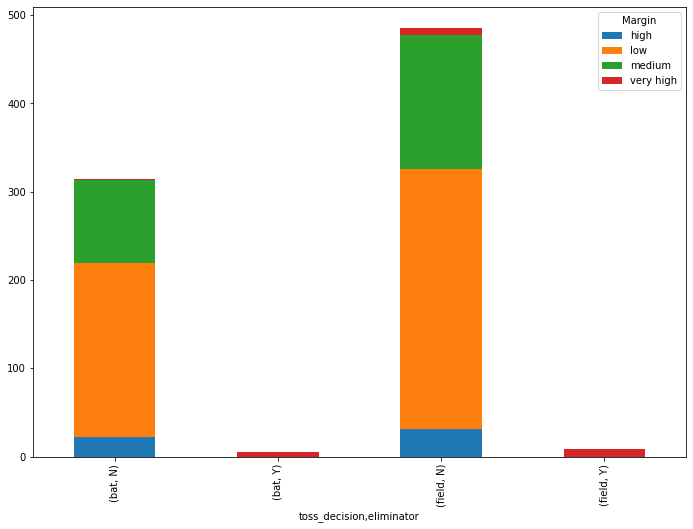

In [ ]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

data_crosstab2 = pd.crosstab([df.toss_decision, df.eliminator], 
                             df.Margin, margins = False)
pl = data_crosstab2.plot(kind = 'bar', stacked = True)

In [ ]:
#toss winner and match winner
spark.sql("SELECT toss_winner, COUNT(*) AS match_wins FROM matches WHERE toss_winner = winner GROUP BY toss_winner ORDER BY match_wins DESC").show()

+--------------------+----------+
|         toss_winner|match_wins|
+--------------------+----------+
| Chennai Super Kings|        61|
|      Mumbai Indians|        61|
|Kolkata Knight Ri...|        55|
|    Rajasthan Royals|        44|
|Royal Challengers...|        43|
|     Kings XI Punjab|        36|
|    Delhi Daredevils|        35|
| Sunrisers Hyderabad|        29|
|     Deccan Chargers|        19|
|       Gujarat Lions|        10|
|      Delhi Capitals|        10|
|Rising Pune Super...|         5|
|Kochi Tuskers Kerala|         4|
|Rising Pune Super...|         3|
|       Pune Warriors|         3|
+--------------------+----------+



In [ ]:
#toss winner but match loser
spark.sql("SELECT toss_winner, COUNT(*) AS match_wins FROM matches WHERE toss_winner != winner GROUP BY toss_winner ORDER BY match_wins DESC").show()

+--------------------+----------+
|         toss_winner|match_wins|
+--------------------+----------+
|     Kings XI Punjab|        49|
|    Delhi Daredevils|        45|
|      Mumbai Indians|        45|
|Royal Challengers...|        44|
|Kolkata Knight Ri...|        43|
|    Rajasthan Royals|        43|
| Chennai Super Kings|        36|
| Sunrisers Hyderabad|        28|
|     Deccan Chargers|        24|
|       Pune Warriors|        17|
|      Delhi Capitals|        10|
|       Gujarat Lions|         5|
|Kochi Tuskers Kerala|         4|
|Rising Pune Super...|         4|
|Rising Pune Super...|         1|
+--------------------+----------+



In [ ]:
#toss winner match winner eliminator 
spark.sql("SELECT toss_winner, COUNT(*) AS match_wins FROM matches WHERE toss_winner = winner AND eliminator LIKE 'Y' GROUP BY toss_winner ORDER BY match_wins DESC").show()

+--------------------+----------+
|         toss_winner|match_wins|
+--------------------+----------+
|    Rajasthan Royals|         1|
|Royal Challengers...|         1|
|      Delhi Capitals|         1|
|     Kings XI Punjab|         1|
|      Mumbai Indians|         1|
+--------------------+----------+



In [ ]:
#toss winner match loser eliminator
spark.sql("SELECT toss_winner, COUNT(*) AS match_wins FROM matches WHERE toss_winner != winner AND eliminator LIKE 'Y' GROUP BY toss_winner ORDER BY match_wins DESC").show()

+--------------------+----------+
|         toss_winner|match_wins|
+--------------------+----------+
|      Mumbai Indians|         2|
| Chennai Super Kings|         1|
|       Gujarat Lions|         1|
|Royal Challengers...|         1|
| Sunrisers Hyderabad|         1|
|     Kings XI Punjab|         1|
|Kolkata Knight Ri...|         1|
+--------------------+----------+



In [ ]:
import sqlite3
con = sqlite3.connect('db')

ball = pd.read_csv(r'/content/ipl_ball_by_ball.csv')
ven = pd.read_csv(r'/content/ipl_venue.csv')

df.to_sql('df', con, if_exists='append', index = False)
ball.to_sql('ball', con, if_exists='append', index = False)
ven.to_sql('ven', con, if_exists='append', index = False)

In [ ]:
class Database(sqlite3.Connection):
    def __init__(self):
        try:
            self = sqlite3.connect(db_location)
            return self
        except sqlite3.DatabaseError as e:
            self.close()
      
    def add_log(self, logtext):
        self.execute()

#*Need to learn more about Section 3*